In [26]:
# https://github.com/eclique/RISE/blob/master/explanations.py

from utils.cub_config import Config
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
import cv2 
from skimage.transform import resize
import matplotlib.pyplot as plt
import os

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model_path = Config.MODEL
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 200)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Usando dispositivo: cuda


C:\Users\Pichau\AppData\Local\Temp\ipykernel_2764\2374464985.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [30]:
class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=10):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch
    
    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        from skimage.transform import resize
        
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size
        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')
        self.masks = np.empty((N, *self.input_size))
        
        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        np.save(savepath, self.masks)
        self.N = N
        self.p1 = p1
    
    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.N = self.masks.shape[0]
    
    def forward(self, x):
        N = self.N
        B, C, H, W = x.size()
        
        # NÃO carregar todas as máscaras na GPU!
        # Processar em batches desde o início
        p_list = []
        
        for i in tqdm(range(0, N, self.gpu_batch), desc='Processing masks'):
            end_idx = min(i + self.gpu_batch, N)
            
            # Carregar apenas o batch de máscaras necessário
            batch_masks = torch.from_numpy(self.masks[i:end_idx]).float().to(x.device)
            
            # Aplicar máscaras na imagem
            stack = torch.mul(batch_masks, x.data)
            
            # Processar com o modelo
            with torch.no_grad():
                batch_p = self.model(stack)
                p_list.append(batch_p.cpu())  # Mover para CPU para economizar memória
            
            # Limpar memória da GPU
            del batch_masks, stack
            torch.cuda.empty_cache()
        
        # Concatenar resultados
        p = torch.cat(p_list).to(x.device)
        
        # Calcular saliency map
        CL = p.size(1)
        
        # Processar máscaras em batches também para o matmul
        sal = torch.zeros((CL, H * W), device=x.device)
        
        for i in range(0, N, self.gpu_batch):
            end_idx = min(i + self.gpu_batch, N)
            batch_masks = torch.from_numpy(self.masks[i:end_idx]).float().to(x.device)
            batch_p = p[i:end_idx]
            
            sal += torch.matmul(batch_p.data.transpose(0, 1), 
                               batch_masks.view(end_idx - i, H * W))
            
            del batch_masks
            torch.cuda.empty_cache()
        
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        
        return sal

In [31]:
input_size = (448, 448)
explainer = RISE(model, input_size, gpu_batch=100)

In [32]:
N = 3000  # Quanto maior, melhor a qualidade (mas mais lento)
s = 8     # Tamanho do grid
p1 = 0.5  # Probabilidade de manter cada célula

print("Gerando máscaras...")
explainer.generate_masks(N=N, s=s, p1=p1, savepath='masks.npy')
# explainer.load_masks('masks.npy')

Gerando máscaras...


Generating filters: 100%|██████████| 3000/3000 [00:21<00:00, 141.68it/s]


In [35]:
image_path = "../data/CUB-200-2011/images/test/027.Shiny_Cowbird/Shiny_Cowbird_0015_796858.jpg"
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)

In [36]:
model = model.to(device)
input_tensor = input_tensor.to(device)

# Gerar saliency map
print("Gerando mapa de saliência...")
with torch.no_grad():
    sal = explainer(input_tensor)

# Obter a predição do modelo
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
confidence = torch.nn.functional.softmax(output, dim=1)[0, pred_class].item()

print(f"Classe predita: {pred_class}")
print(f"Confiança: {confidence:.4f}")

Gerando mapa de saliência...


Processing masks: 100%|██████████| 30/30 [09:37<00:00, 19.27s/it]


Classe predita: 26
Confiança: 0.1876


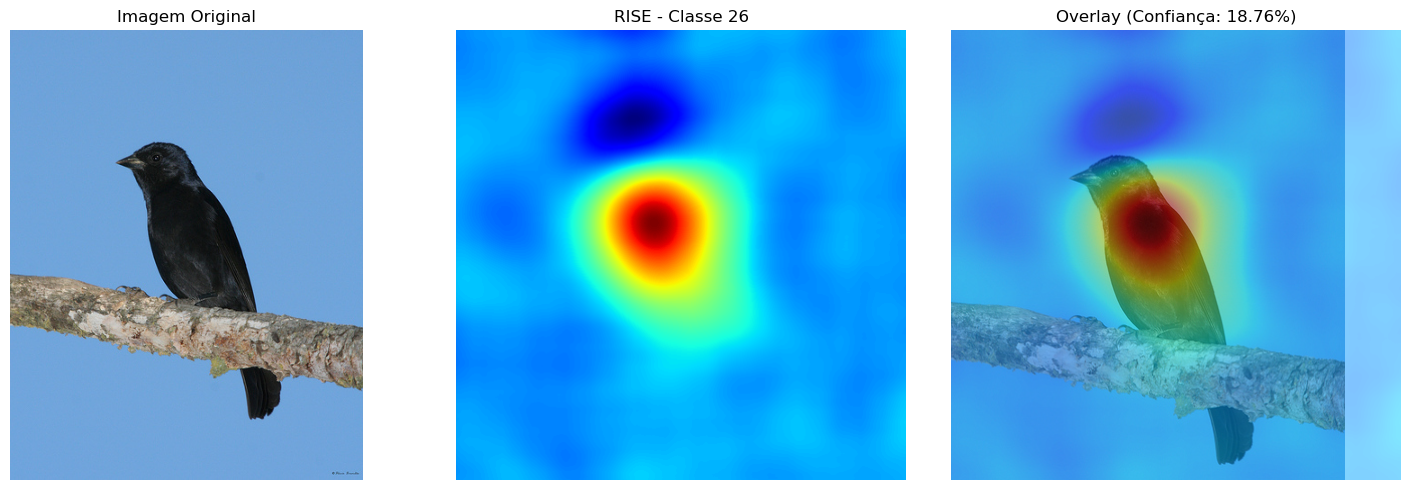

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Imagem original
img_display = np.array(img)
axes[0].imshow(img_display)
axes[0].set_title('Imagem Original')
axes[0].axis('off')

# Saliency map da classe predita
sal_map = sal[pred_class].cpu().numpy()
axes[1].imshow(sal_map, cmap='jet')
axes[1].set_title(f'RISE - Classe {pred_class}')
axes[1].axis('off')

# Overlay
axes[2].imshow(img_display)
axes[2].imshow(sal_map, cmap='jet', alpha=0.5)
axes[2].set_title(f'Overlay (Confiança: {confidence:.2%})')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('rise_explanation.png', dpi=150, bbox_inches='tight')
plt.show()
